In [10]:
import torch
from fastai.vision.all import *
import os

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

CUDA is available on this system.


In [11]:
# Fix Display behavior in Jupyter Notebooks for VS Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [12]:
def get_label_func(file_name, labels_file):
    # Load the JSON file with class labels
    with open(labels_file, "r") as f:
        labels_data = json.load(f)

    # Extract the class label based on the file name
    tl = labels_data[file_name]
    return tl["state"] + tl["pictogram"]

In [14]:
dataset_path = "/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined"

train_folder = 'train'
valid_folder = 'valid'

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=lambda file_path: get_label_func(os.path.basename(file_path), dataset_path + '/labels.json'),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
                   batch_tfms=None)

dls = dblock.dataloaders(dataset_path, path=dataset_path, train=train_folder, valid=valid_folder, bs=64)


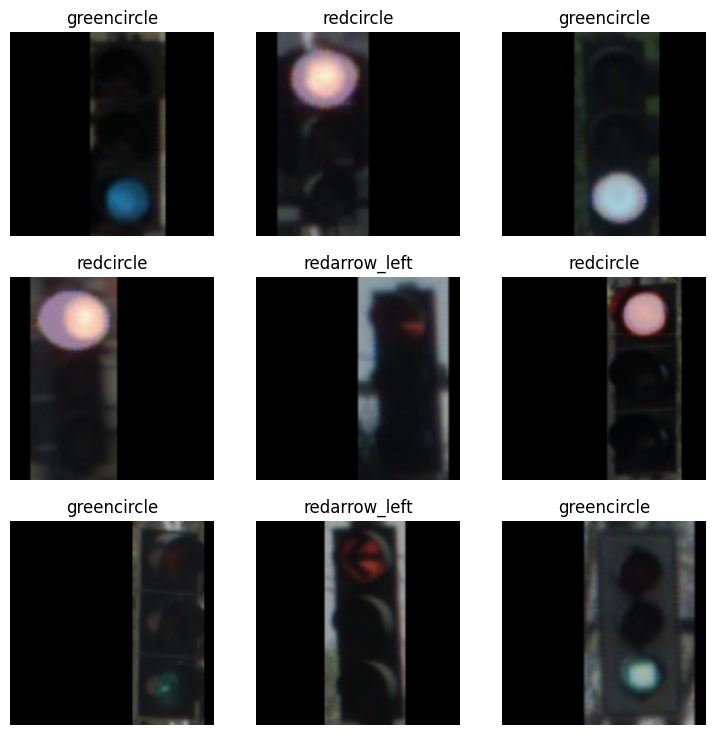

In [15]:
dls.show_batch(max_n=9)

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

SuggestedLRs(valley=0.0006918309954926372)

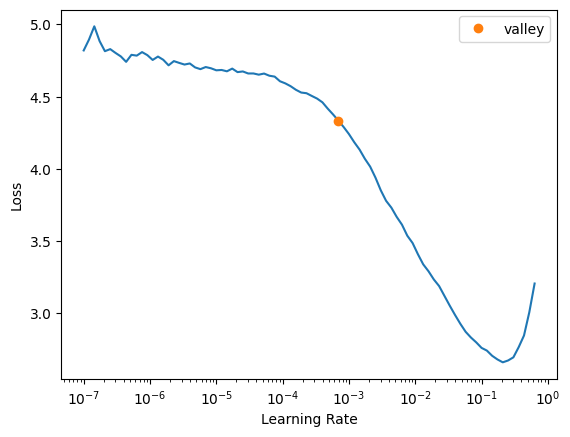

In [21]:
learn.lr_find()

In [22]:
learn.fine_tune(4, 4e-3)

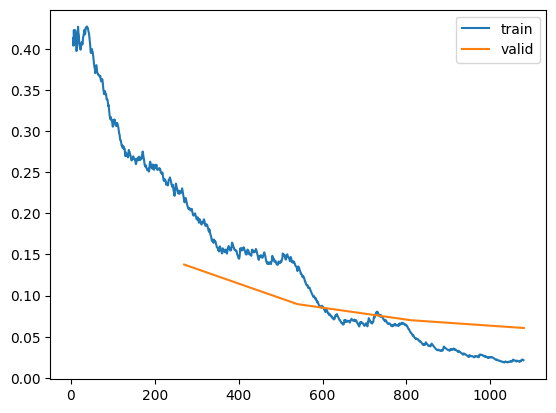

In [23]:
learn.recorder.plot_loss()

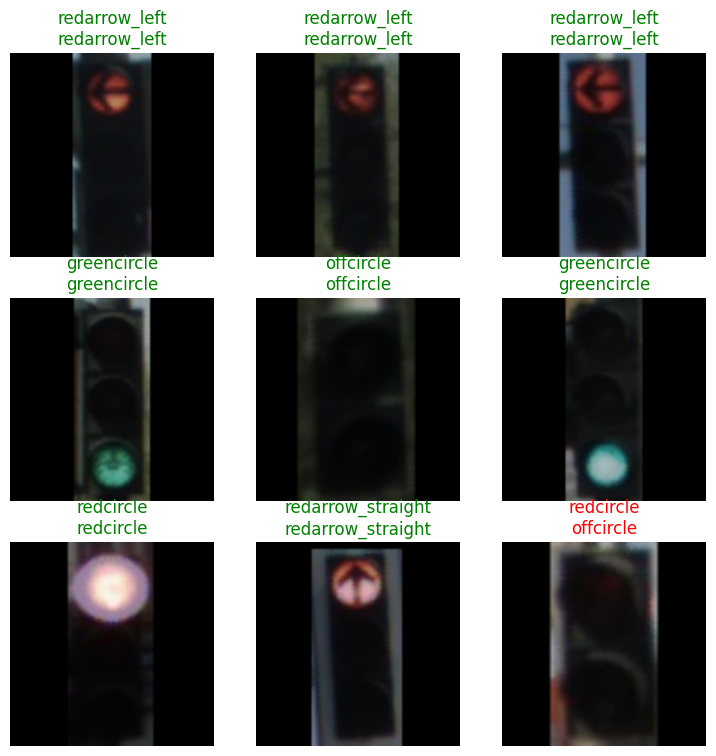

In [24]:
learn.show_results()


In [25]:
learn.save('tl_v1')

Path('/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined/models/tl_v1.pth')

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

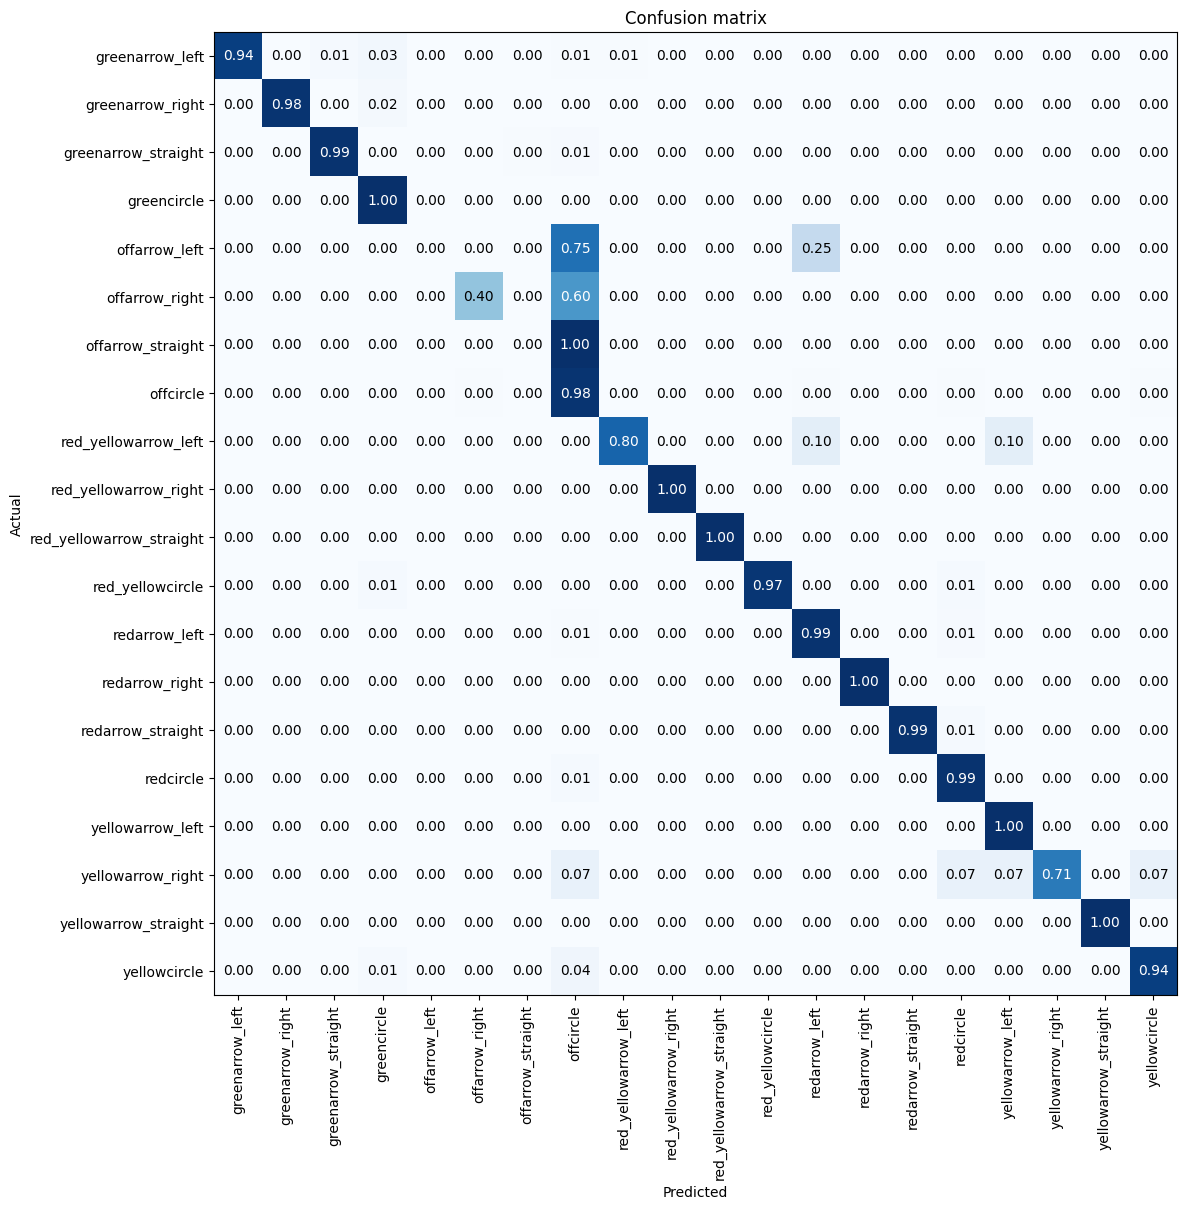

In [31]:
interp.plot_confusion_matrix(normalize=True, figsize=(12, 12))

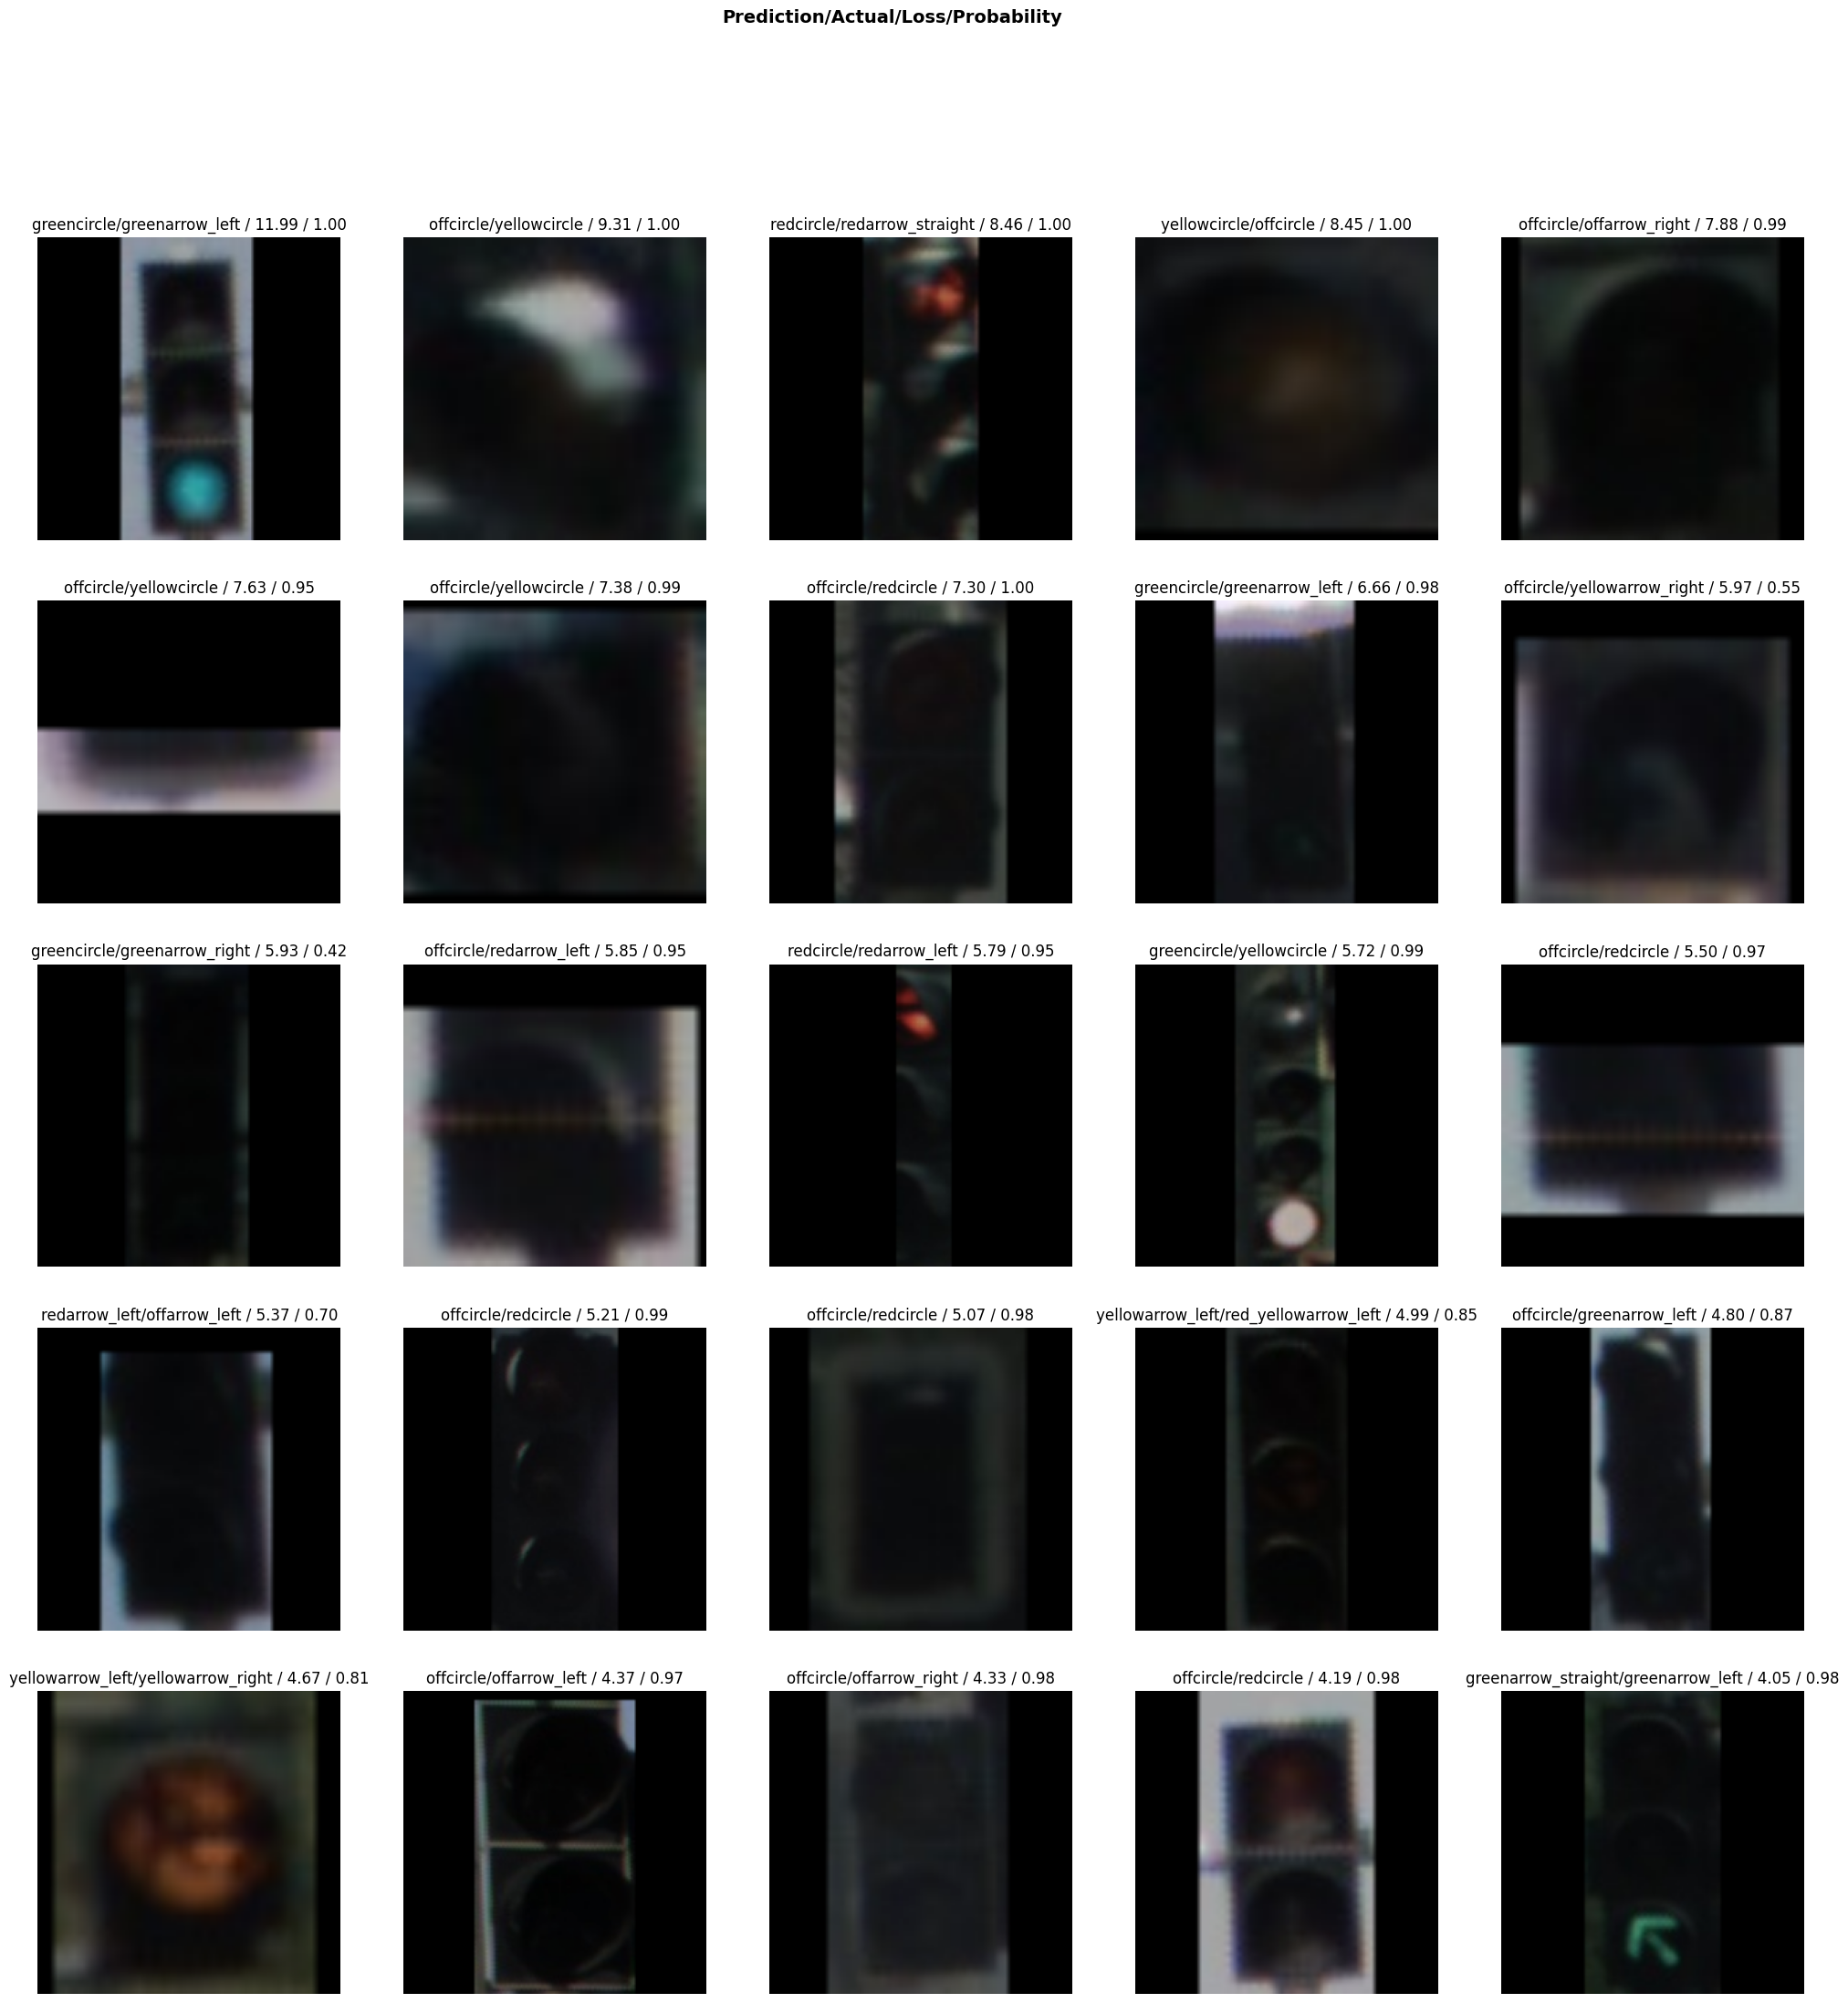

In [34]:
interp.plot_top_losses(25, figsize=(25, 25))

Image file: /home/ippen/personal/traffic-light-classification/datasets/samples/img1.png
Predicted class: greenarrow_left
Probabilities: tensor([9.5796e-01, 1.3855e-04, 3.3806e-03, 2.1418e-03, 5.1947e-04, 1.3353e-05,
        7.1771e-05, 1.0703e-04, 1.3598e-04, 3.2437e-06, 1.0754e-05, 9.8292e-06,
        1.6176e-03, 2.3573e-06, 1.1990e-06, 8.6585e-07, 3.3776e-02, 6.5330e-05,
        2.2876e-05, 2.0814e-05])
--------------------


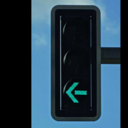

In [40]:
sample_folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"
sample_image_files = get_image_files(sample_folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')
# Iterate over the image files and make predictions
#for image_file in sample_image_files:
image_file = sample_image_files[0]
img = PILImage.create(image_file)
cropped_img = crop_transform(img)

# Use the learner to predict the image
prediction = learn.predict(cropped_img)

# Access the predicted class and associated probabilities
predicted_class = prediction[0]
probabilities = prediction[2]

# Print the predicted class and probabilities for the current image

print(f"Image file: {image_file}")
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")
print("--------------------")
cropped_img.to_thumb(128)

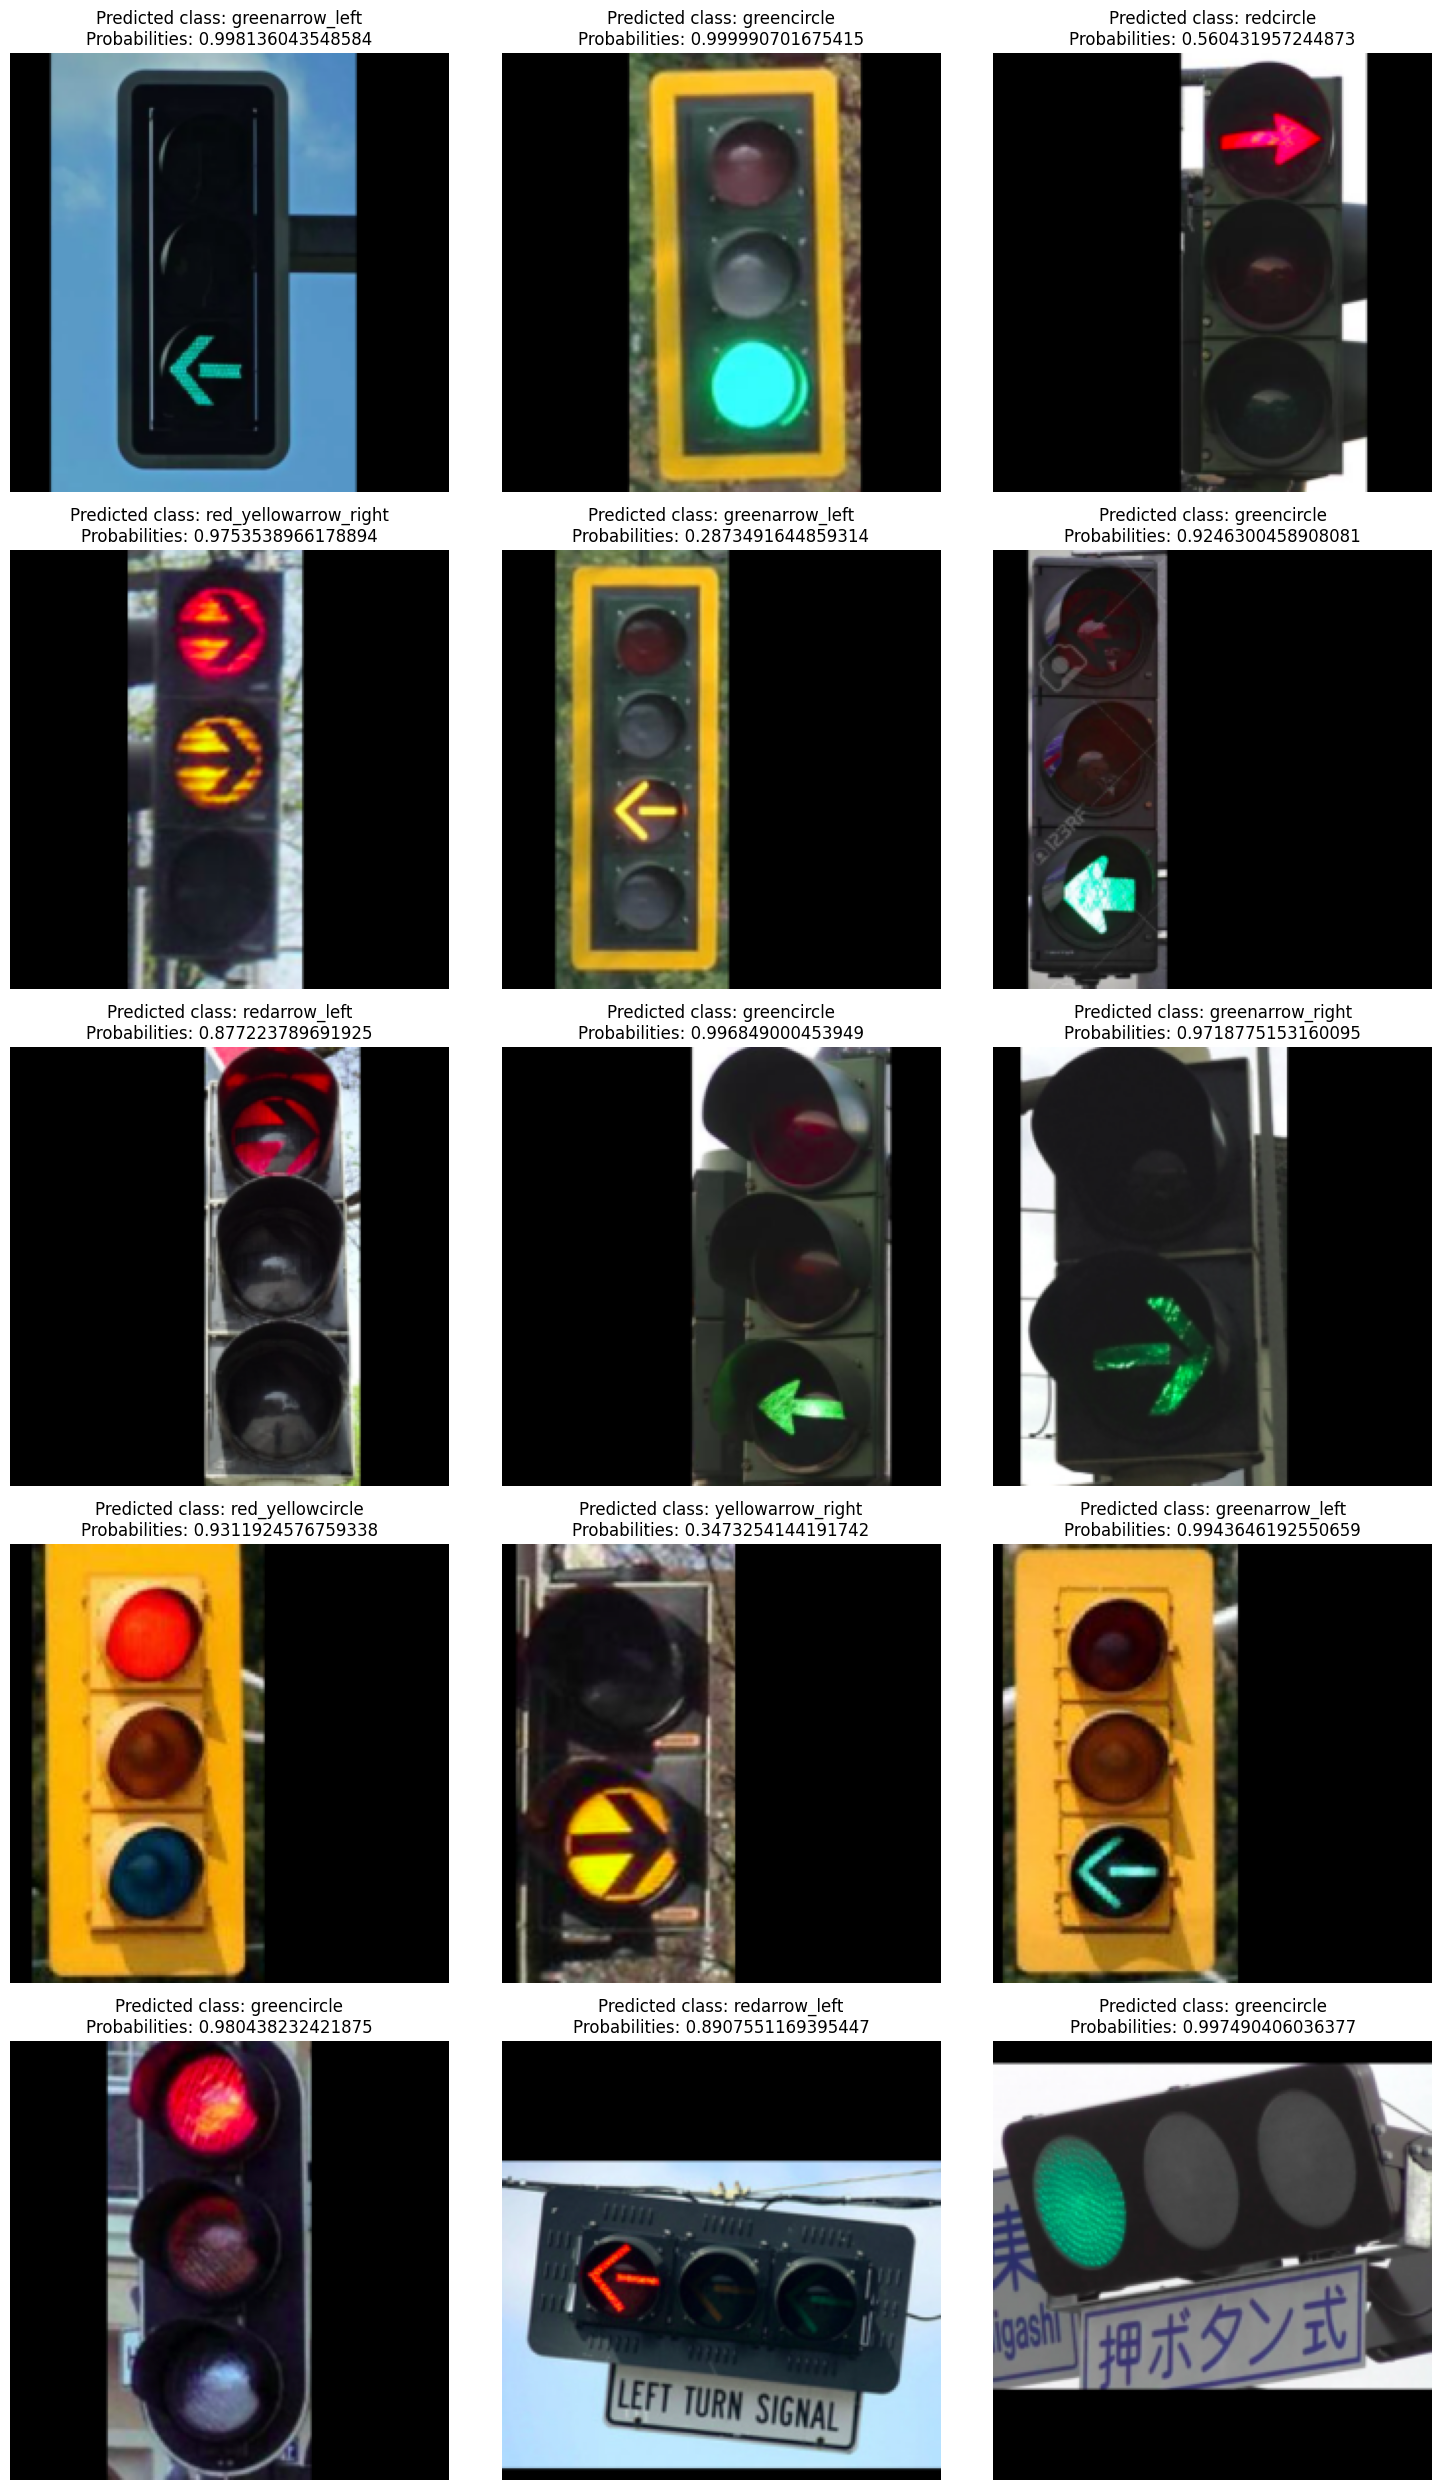

In [45]:
import matplotlib.pyplot as plt

folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')

# Calculate the number of rows and columns for the subplot grid
num_images = len(image_files)
num_cols = 3  # Number of columns in the grid
num_rows = (num_images - 1) // num_cols + 1  # Number of rows in the grid

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate over the image files and make predictions
for idx, image_file in enumerate(image_files):
    img = PILImage.create(image_file)
    
    # Apply the cropping transformation to the image
    cropped_img = crop_transform(img)

    # Use the learner to predict the cropped image
    prediction = learn.predict(cropped_img)

    # Access the predicted class and associated probabilities
    predicted_class = prediction[0]
    probabilities = prediction[2]

    # Plot the image and display the predicted class and probabilities
    ax = axs[idx // num_cols, idx % num_cols]
    ax.imshow(cropped_img)
    ax.axis('off')
    ax.set_title(f"Predicted class: {predicted_class}\nProbabilities: {max(probabilities)}")

# Adjust the spacing between subplots and display the plot
plt.tight_layout()
plt.show()

### Results
- Decent first results, but sometimes fatal errors on new images.
- The naive way of completely independent classes should be addressed in the next version by adding Multi-Target classes 